En este notebook usamos los datos del notebook 8 para entrenar y validar, y hemos añadido una augmentación de datos más moderada, corregido un error del earlystopping (estaba en modo automático, el cual estaba buscando que la metrica a monitorizar se considerara que mejore al reducirse, cuando queremos realmente lo contrario, así que lo puse que se fuerce a que la mejora del val_auc sea cuando este valor aumente), a su vez he creado una función para que a partir de una lista de valores de ratio de verdaderos positivos devuelva los valores de falsos positivos de la red así como los umbrales necesarios para cada uno de ellos

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt
import glob
import shutil
import logging

import random
from random import shuffle

import imgaug as ia
import imgaug.augmenters as iaa

logger = tf.get_logger()
logger.setLevel(logging.ERROR)


print("Num GPUS avadible:",len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUS avadible: 1


In [2]:
classes = ['0', '1', '2', '3', '4']

base_dir=os.path.join( 'prop')

train_dir = os.path.join( 'test_2cat' )
test_dir = os.path.join('val1_2cat')


In [3]:

val_dir = test_dir

train_0 = os.path.join(train_dir, '0') 
train_1 = os.path.join(train_dir, '1')
#train_2 = os.path.join(train_dir, '2') 
#train_3 = os.path.join(train_dir, '3')  
#train_4 = os.path.join(train_dir, '4') 

val_0 = os.path.join(val_dir, '0') 
val_1 = os.path.join(val_dir, '1')
#val_2 = os.path.join(val_dir, '2') 
#val_3 = os.path.join(val_dir, '3')  
#val_4 = os.path.join(val_dir, '4')  


#numeros
num_0_tr = len(os.listdir(train_0))
num_1_tr = len(os.listdir(train_1))
#num_2_tr = len(os.listdir(train_2))
#num_3_tr = len(os.listdir(train_3))
#num_4_tr = len(os.listdir(train_4))


num_0_v = len(os.listdir(val_0))
num_1_v = len(os.listdir(val_1))
#num_2_v = len(os.listdir(val_2))
#num_3_v = len(os.listdir(val_3))
#num_4_v = len(os.listdir(val_4))


total_train = num_0_tr + num_1_tr #+ num_2_tr + num_3_tr + num_4_tr
total_val = num_0_v + num_1_v #+ num_2_v + num_3_v + num_4_v
 

In [4]:
def rescale_0_to_1(image):
    """
    Rescale image to [0, 1].
    :param image:
        Required. Image tensor.
    :return:
        Scaled image.
    """
    return tf.image.convert_image_dtype(image, tf.float64)

def rescale_min_1_to_1(image):
    """
    Rescale image to [-1, 1].
    :param image:
        Required. Image tensor.
    :return:
        Scaled image.
    """
    # Image must be casted to float32 first.
    image = tf.cast(image, tf.float64)
    # Rescale image from [0, 255] to [0, 2].
    image = tf.multiply(image, 1. / 127.5)
    # Rescale to [-1, 1].
    return tf.subtract(image, 1.0)

In [5]:
def augment_pre(image):
    
    BRIGHTNESS_MIN_DELTA = 0.875
    BRIGHTNESS_MAX_DELTA = 1.125

    SATURATION_LOWER = 0.5
    SATURATION_UPPER = 1.5

    HUE_MIN_DELTA = 0.8
    HUE_MAX_DELTA = 1.2

    CONTRAST_LOWER = 0.5
    CONTRAST_UPPER = 1.5
    
    seq = iaa.Sequential([
        iaa.MultiplyBrightness((BRIGHTNESS_MIN_DELTA, BRIGHTNESS_MAX_DELTA)),
        iaa.Fliplr(0.5),
        iaa.Flipud(0.5), 
        iaa.LinearContrast((CONTRAST_LOWER,CONTRAST_UPPER)),
        iaa.MultiplyHue((HUE_MIN_DELTA, HUE_MAX_DELTA)),
        iaa.MultiplySaturation((SATURATION_LOWER, SATURATION_UPPER)),

    ], random_order=True) # apply augmenters in random order
    image=image.astype(np.uint8)
    image=seq(image=image)

    image= rescale_min_1_to_1(image)
    
    return image

In [6]:
img_height=299
img_width=299
batch_size=16


In [7]:
image_gen_train = ImageDataGenerator(
      preprocessing_function=augment_pre
)

train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(img_height,img_width),
                                                     class_mode='binary'
                                                     )

Found 48664 images belonging to 2 classes.


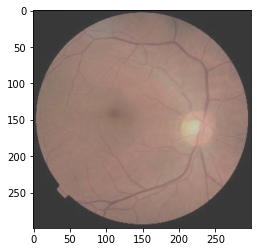

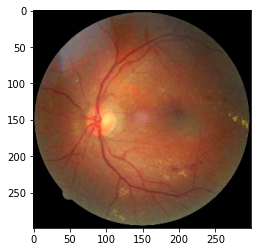

In [8]:

x,y= train_data_gen.next()

for i in range(0,2):
    image = x[i]
    plt.imshow((image+1)/2)
    plt.show()

In [9]:
image_gen_test = ImageDataGenerator(
    preprocessing_function=rescale_min_1_to_1
)

test_data_gen = image_gen_test.flow_from_directory(batch_size=batch_size,
                                                   directory=val_dir,
                                                   target_size=(img_height,img_width),
                                                   class_mode='binary'
                                                  )

Found 19999 images belonging to 2 classes.


In [10]:
import math  
    
number_of_examples = len(test_data_gen.filenames)
number_of_generator_calls = math.ceil(number_of_examples / (1.0 * batch_size)) 
# 1.0 above is to skip integer division

test_labels = []

for i in range(0,int(number_of_generator_calls)):
    test_labels.extend(np.array(test_data_gen[i][1]))

In [11]:

with tf.device('/GPU:0'):
    model = tf.keras.models.Sequential([
        tf.keras.applications.InceptionV3(include_top=False, weights='imagenet', pooling='avg'),
        tf.keras.layers.Dense(1,activation='sigmoid')
    ])
    
    



    model.compile(optimizer= tf.keras.optimizers.RMSprop(learning_rate=1e-4,decay=4e-5),
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=['accuracy',tf.keras.metrics.AUC()])

    model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 2048)              21802784  
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
Total params: 21,804,833
Trainable params: 21,770,401
Non-trainable params: 34,432
_________________________________________________________________


In [12]:

callbacks = [
    
    tf.keras.callbacks.EarlyStopping(
         monitor='val_auc', min_delta=0.001 , patience=20, verbose=0, mode='max',
        baseline=None, restore_best_weights=True
    ),
    
]

In [13]:
with tf.device('/GPU:0'):
    epochs=200
    history = model.fit(
        train_data_gen,
        steps_per_epoch=int(np.floor(total_train / float(batch_size))),
        epochs=epochs,
        validation_data=test_data_gen,
        validation_steps=int(np.ceil(total_val / float(batch_size))),
        callbacks=callbacks,
    )

Train for 3041 steps, validate for 1250 steps
Epoch 1/200
3041/3041 [==============================] - 2035s 669ms/step - loss: 0.6857 - accuracy: 0.7404 - auc: 0.5948 - val_loss: 0.6796 - val_accuracy: 0.7722 - val_auc: 0.6279
Epoch 2/200
3041/3041 [==============================] - 2017s 663ms/step - loss: 0.6798 - accuracy: 0.7560 - auc: 0.6277 - val_loss: 0.6801 - val_accuracy: 0.7817 - val_auc: 0.6554
Epoch 3/200
3041/3041 [==============================] - 2018s 663ms/step - loss: 0.6762 - accuracy: 0.7655 - auc: 0.6454 - val_loss: 0.6810 - val_accuracy: 0.7889 - val_auc: 0.7029
Epoch 4/200
3041/3041 [==============================] - 2043s 672ms/step - loss: 0.6735 - accuracy: 0.7729 - auc: 0.6626 - val_loss: 0.6729 - val_accuracy: 0.7850 - val_auc: 0.6390
Epoch 5/200
3041/3041 [==============================] - 2023s 665ms/step - loss: 0.6718 - accuracy: 0.7775 - auc: 0.6697 - val_loss: 0.6685 - val_accuracy: 0.8030 - val_auc: 0.7062
Epoch 6/200
3041/3041 [=====================

3041/3041 [==============================] - 2032s 668ms/step - loss: 0.6484 - accuracy: 0.8373 - auc: 0.7498 - val_loss: 0.6606 - val_accuracy: 0.8262 - val_auc: 0.7248
Epoch 46/200
3041/3041 [==============================] - 2016s 663ms/step - loss: 0.6476 - accuracy: 0.8392 - auc: 0.7534 - val_loss: 0.6600 - val_accuracy: 0.8259 - val_auc: 0.7211
Epoch 47/200
3041/3041 [==============================] - 2051s 674ms/step - loss: 0.6486 - accuracy: 0.8366 - auc: 0.7502 - val_loss: 0.6610 - val_accuracy: 0.8284 - val_auc: 0.7296
Epoch 48/200
3041/3041 [==============================] - 2017s 663ms/step - loss: 0.6472 - accuracy: 0.8399 - auc: 0.7530 - val_loss: 0.6599 - val_accuracy: 0.8261 - val_auc: 0.7148
Epoch 49/200
3041/3041 [==============================] - 2016s 663ms/step - loss: 0.6477 - accuracy: 0.8382 - auc: 0.7510 - val_loss: 0.6606 - val_accuracy: 0.8295 - val_auc: 0.7342
Epoch 50/200
3041/3041 [==============================] - 2022s 665ms/step - loss: 0.6473 - accura

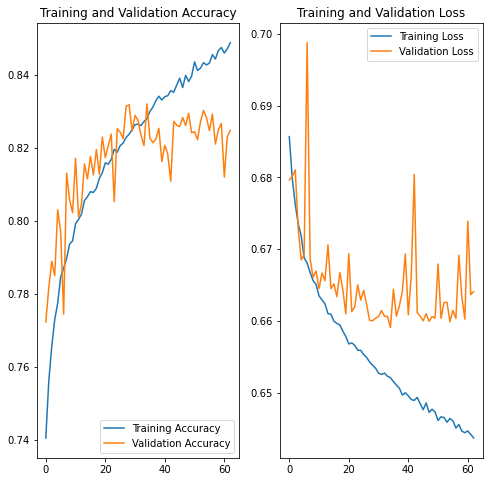

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [15]:
y_pred =  model.predict_generator(test_data_gen, steps= int(np.ceil(total_val / float(batch_size))))

In [16]:
print(y_pred.shape)

(19999, 1)


In [17]:
print(len(test_labels))

19999


In [18]:
from sklearn.metrics import roc_curve,roc_auc_score

fpr , tpr , thresholds = roc_curve ( test_labels , y_pred)



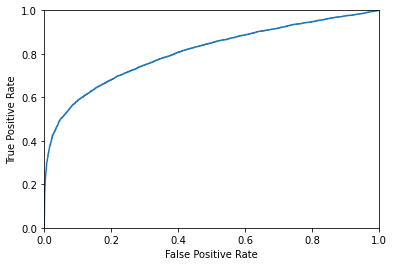

In [19]:
def plot_roc_curve(fpr,tpr): 
  plt.plot(fpr,tpr) 
  plt.axis([0,1,0,1]) 
  plt.xlabel('False Positive Rate') 
  plt.ylabel('True Positive Rate') 
  plt.show()    
  
plot_roc_curve (fpr,tpr) 

Mantenemos resultados nefastos para el set de validación, aunque el nuevo optimizador con los nuevos parámetros proporciona un aprendizaje más rápido en el set de entrenamiento.

In [20]:
fpr[(np.where(tpr>=0.80))[0][0]]


0.38912879566796904

In [21]:

def tpr_to_umbrales(tpr,fpr,thresholds,lista):
    umbrales=[]
    fprumb=[]
    
    for i in lista:
        umbrales.append(thresholds[(np.where(tpr>=i))[0][0]])
        fprumb.append(fpr[(np.where(tpr>=i))[0][0]])
    
    return (umbrales, fprumb)  

In [22]:
lista=[0.98,0.95,0.90,0.80]
  

umbrales , fprumb =tpr_to_umbrales(tpr,fpr,thresholds,lista)

for idx,i in enumerate(lista):
    print("tpr:"+str(i)+"->fpr: "+str(fprumb[idx])+" con umbral: "+str(umbrales[idx]))

tpr:0.98->fpr: 0.9271368839536637 con umbral: 3.238242e-36
tpr:0.95->fpr: 0.8097196517924463 con umbral: 1.6591495e-31
tpr:0.9->fpr: 0.6331482623894715 con umbral: 3.8270749e-25
tpr:0.8->fpr: 0.38912879566796904 con umbral: 6.5816963e-15


In [23]:
# Guardar el Modelo
model.save('prueban14.h5')

# Recrea exactamente el mismo modelo solo desde el archivo
#new_model = tf.keras.models.load_model('miniprueba2.h5')